## LLM

In [7]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [8]:
tokenizer = pkl.load(open('tokenizer.pkl', 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/corpus_indicies.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 256
embed_dim = 1024
tf_blocks = 8
heads = 8
ff_dim = 4096

unembed_dims = [512]

model = Transformer(vocab_size=tokenizer.vocab_size,
                          max_seq_len=max_seq_len,
                          embed_dim=embed_dim,
                          tf_blocks=tf_blocks,
                          heads=heads,
                          ff_dim = ff_dim,
                          unembed_dims=unembed_dims,
                          lr=0.0001,)

losses_train = []
losses_test = []


In [10]:
ckpt = tf.train.Checkpoint(
    optimizer=model.optimizer,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/model1",      # folder where ckpts are saved
    max_to_keep=5                  # only keep 5 latest checkpoints
)


In [11]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [12]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 102283246


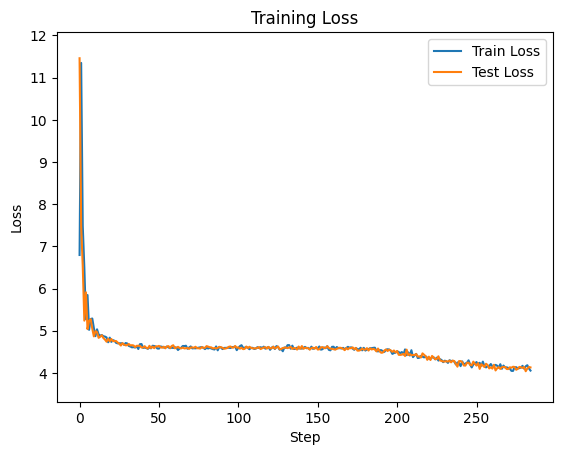

KeyboardInterrupt: 

In [13]:
batch_size = 16
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:8000], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    
    loss_train = model.train_step(indices, y_true)
    losses_train.append(loss_train)

    indices, y_true = sample_batch(corpus_indicies[8000:], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    loss_test = model.evaluate(indices, y_true)
    losses_test.append(loss_test)

    if i % 1000 == 0:
        ckpt_manager.save()


    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_train[-400:], label="Train Loss")
    plt.plot(x, losses_test[-400:], label="Test Loss")

    Min = np.min(losses_train[-400:])
    Max = np.max(losses_train[-400:])
    delta = Max - Min
    plt.ylim(Min - delta*0.1, Max + delta*0.1)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

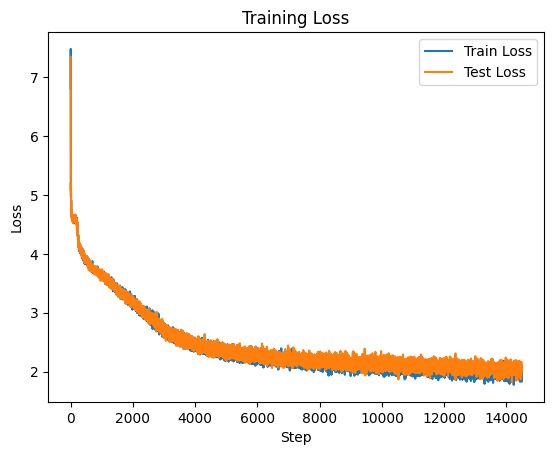

In [ ]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(corpus[0])

It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria.

Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons.

The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."

It's a step that is set to turn an international crisis into a fierce domestic political battle.

There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react?

In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because he wa

In [ ]:
text = "Obama's remarks came shortly after"
indices = tf.cast(tf.expand_dims(tokenizer.tokenize(text), axis=0), tf.int32)
print(indices)

tf.Tensor(
[[ 48  67 135  66 136   1 100 486  76  84   1  68 340   1 204 213 138   1
  335]], shape=(1, 19), dtype=int32)


In [ ]:
T = 0.4
tf.random.set_seed(42)
for i in range(256):
    logits = transformer.pred(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


KeyboardInterrupt: 

## 